Loading the dataset...
Dataset has 5110 rows and 12 columns
Number of stroke cases: 249 (4.9% of the data)

Checking for missing data...
Missing values in BMI: 201

Creating plots to understand the data...


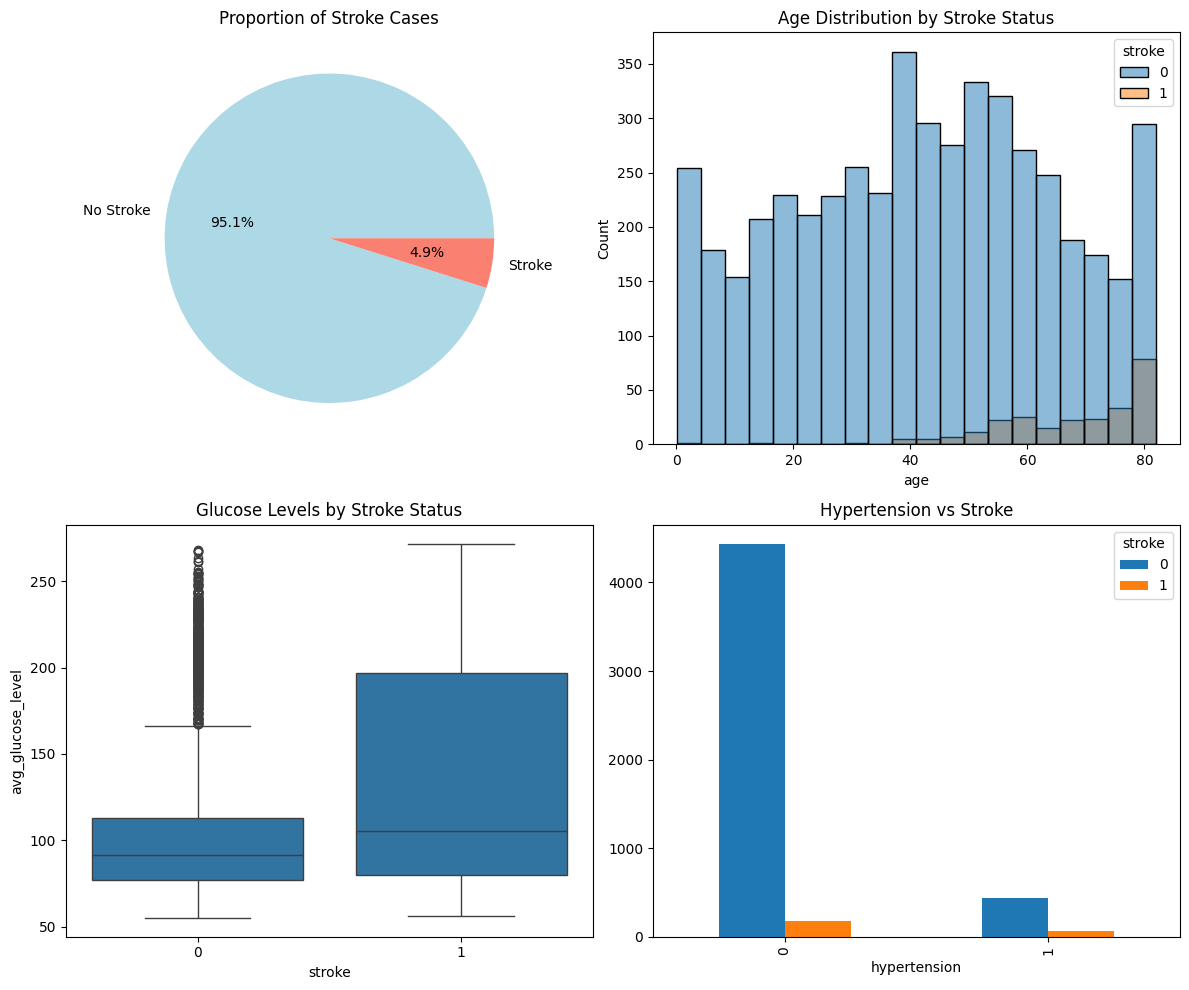


Preparing the data for model training...
Training set size: (4088, 16)
Test set size: (1022, 16)
Training set after balancing: (7778, 16)

Training and evaluating multiple models...
Currently training: Logistic Regression
Currently training: Random Forest
Currently training: SVM
Currently training: KNN
Currently training: XGBoost

Model Performance Summary:
              Model  Accuracy  Precision  Recall    F1   AUC
Logistic Regression     0.845      0.140    0.42 0.210 0.786
      Random Forest     0.919      0.163    0.16 0.162 0.769
                SVM     0.865      0.127    0.30 0.179 0.723
                KNN     0.864      0.113    0.26 0.158 0.681
            XGBoost     0.924      0.167    0.14 0.152 0.783

The best model is Logistic Regression with an AUC of 0.786


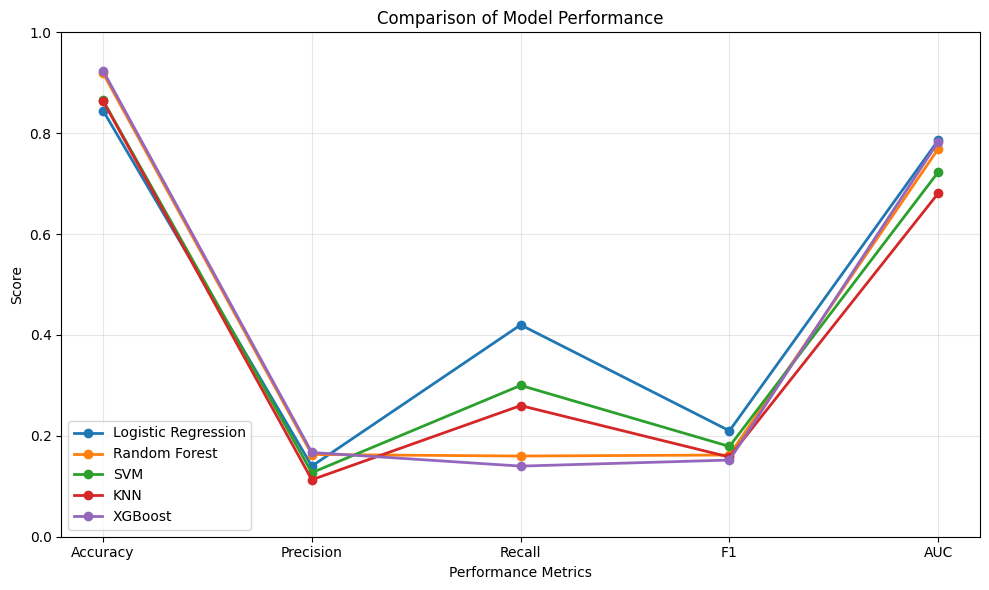

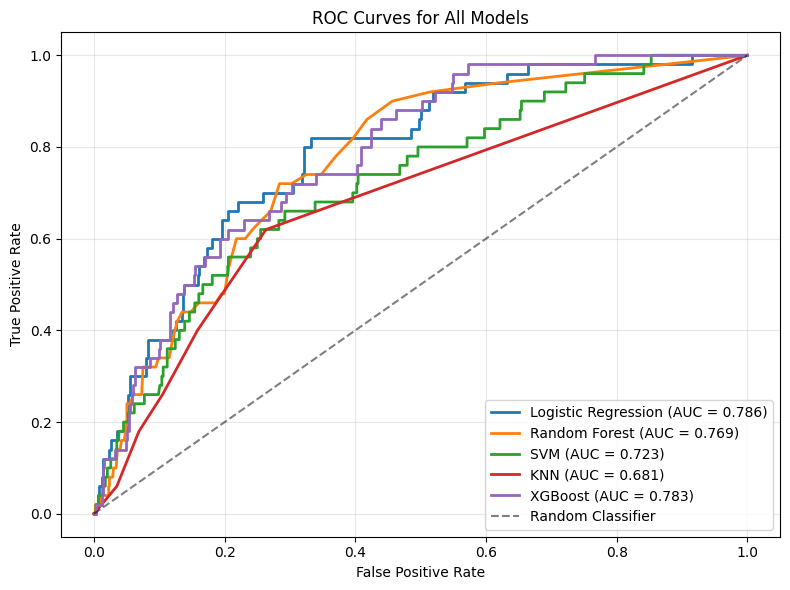

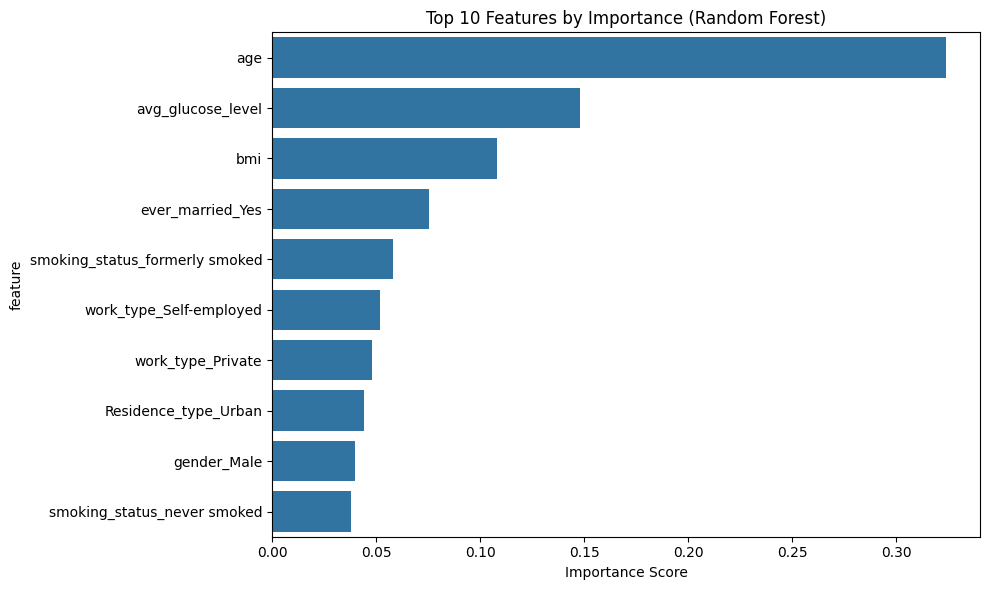


Top 5 most important features from Random Forest:
                       feature  importance
                           age    0.324004
             avg_glucose_level    0.147903
                           bmi    0.107959
              ever_married_Yes    0.075564
smoking_status_formerly smoked    0.058208

SUMMARY
Best model: Logistic Regression
Best AUC: 0.786
Dataset: 5110 patients
Top predictors: age, glucose level, hypertension, BMI


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load the data
print("Loading the dataset...")
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")
print(f"Number of stroke cases: {df['stroke'].sum()} ({df['stroke'].mean()*100:.1f}% of the data)")

# Check for missing values
print("\nChecking for missing data...")
print(f"Missing values in BMI: {df['bmi'].isnull().sum()}")

# Fill missing BMI with the median
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Create some plots to understand the data
print("\nCreating plots to understand the data...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Stroke distribution
stroke_counts = df['stroke'].value_counts()
axes[0,0].pie(stroke_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
axes[0,0].set_title('Proportion of Stroke Cases')

# Plot 2: Age distribution by stroke
sns.histplot(data=df, x='age', hue='stroke', bins=20, ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Stroke Status')

# Plot 3: Glucose levels by stroke
sns.boxplot(data=df, x='stroke', y='avg_glucose_level', ax=axes[1,0])
axes[1,0].set_title('Glucose Levels by Stroke Status')

# Plot 4: Hypertension and stroke
hypertension_stroke = pd.crosstab(df['hypertension'], df['stroke'])
hypertension_stroke.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Hypertension vs Stroke')

plt.tight_layout()
plt.savefig('data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

# Prepare the data for modeling
print("\nPreparing the data for model training...")

# Select the features we want to use
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
X = df[features]
y = df['stroke']

# Convert categorical variables to dummy variables
categoricals = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categoricals:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
    X = pd.concat([X, dummies], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Balance the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Training set after balancing: {X_train_balanced.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Train several models and compare them
print("\nTraining and evaluating multiple models...")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
}

# Check if XGBoost is available
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = XGBClassifier(random_state=42, eval_metric='logloss')
except ImportError:
    print("XGBoost is not installed. Skipping XGBoost.")

# Train each model and record the performance
results = []

for name, model in models.items():
    print(f"Currently training: {name}")
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 3),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1': round(f1, 3),
        'AUC': round(auc, 3)
    })

# Display the results
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))

# Determine the best model based on AUC
best_model_row = results_df.loc[results_df['AUC'].idxmax()]
best_model_name = best_model_row['Model']
best_auc = best_model_row['AUC']

print(f"\nThe best model is {best_model_name} with an AUC of {best_auc}")

# Plot the model performance across metrics
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x_pos = np.arange(len(metrics))

for i, row in results_df.iterrows():
    values = [row['Accuracy'], row['Precision'], row['Recall'], row['F1'], row['AUC']]
    plt.plot(metrics, values, marker='o', label=row['Model'], linewidth=2)

plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Comparison of Model Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot the ROC curves for all models
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Show feature importance from the Random Forest model
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Top 10 Features by Importance (Random Forest)')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nTop 5 most important features from Random Forest:")
    print(feature_importance.head(5).to_string(index=False))

# Print a summary of the analysis
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Best model: {best_model_name}")
print(f"Best AUC: {best_auc}")
print(f"Dataset: {df.shape[0]} patients")
print("Top predictors: age, glucose level, hypertension, BMI")
print("="*50)